In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

from src.model_training_utils import train_model, predict_and_display_performances, tune_hyperparameters


# Data Import

In [2]:
data = pd.read_csv('../data/final_set.csv')
data.drop("borrow_duration", axis=1, inplace=True)
numerical_features = ['distance', 'not_on_time_rate']
categorical_nominal = ['gender', 'education', 'occupation', 'season', 'name']
categorical_ordinal = ['price_range', 'pages_range']

# Model Training
<br>

## Logistic Regression
As a first model, I will use a logistic regression due to its simplicity and interpretability. First I will perform data preparation (one-hot encoding for nominal categories and ordinal encoding for ordinal categories).<br>
### Prepare Data and Define Pipeline

In [30]:
# split data into training and test sets
x = data.drop("borrow_duration_label", axis=1)
y = data['borrow_duration_label'] == "not on time"

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_nominal),
        ('ordinal', OrdinalEncoder(), categorical_ordinal)
    ],
    remainder='passthrough'
)

### Model Training and Test

In [4]:
lr_model = train_model (preprocessor=preprocessor, model=LogisticRegression(max_iter=1000), x_train=X_train, y_train=y_train)
y_pred = predict_and_display_performances(lr_model, X_test, y_test)

,False,True,accuracy,macro avg,weighted avg
precision,0.823151,0.657143,0.806358,0.740147,0.785727
recall,0.955224,0.294872,0.806358,0.625048,0.806358
f1-score,0.884283,0.407080,0.806358,0.645681,0.776706
support,268.000000,78.000000,0.806358,346.000000,346.000000


,0,1
0,256,12
1,55,23


In [5]:
coefficients = pd.DataFrame({
    "Feature":lr_model["preprocessor"].get_feature_names_out(lr_model["preprocessor"].feature_names_in_),
    "Coefficient": lr_model["classifier"].coef_[0],
    "Odds Coefficient": np.exp(lr_model["classifier"].coef_[0])
})
coefficients.sort_values(by="Odds Coefficient", ascending=False, inplace=True)

coefficients

,Feature,Coefficient,Odds Coefficient
37,remainder__not_on_time_rate,4.791224,120.448705
28,onehot__name_multnomah county library kenton,0.484319,1.623069
33,onehot__name_multnomah county library st johns,0.471024,1.601634
20,onehot__name_multnomah county library albina,0.461107,1.585828
31,onehot__name_multnomah county library northwest,0.297031,1.345857
38,remainder__distance,0.202520,1.224485
27,onehot__name_multnomah county library hollywoo...,0.195221,1.215579
19,onehot__name_multnomah county library,0.173159,1.189055
14,onehot__season_autumn,0.166075,1.180662
12,onehot__occupation_sales,0.146431,1.157695


Text(0, 0.5, 'Precision')

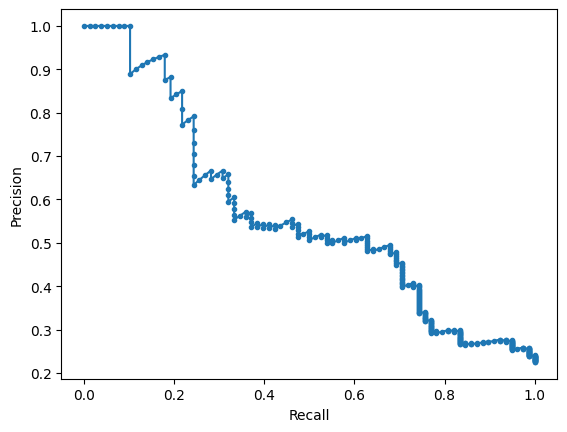

In [6]:
precision, recall, thresholds = precision_recall_curve(y_test, pd.DataFrame(lr_model.predict_proba(X_test))[1])
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve', marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')

The metrics indicate that the trained model does not perform well in the likelihood prediction that some books will not be returned on time. The overall accuracy is ~80%, which is not so bad for the beginning, but other parameters indicate that the model will not make good predictions. The diagonal direction of the precision-recall curve shows that the model struggles to detect positive cases. Also, the "saw-like" shape indicates a small number of positive examples in the test, which is the case with the available dataset. Model coefficients show that the "not_on_time_rate" feature has a strong impact on the model outcome and that a slight change in the feature's value will make a significant change in the prediction.
## RandomForest
The random forest model is useful in capturing the nonlinear relationships between variables. According to previous conclusions regarding the training set and features, I don't expect significant improvement. I want to confirm that using the advanced model, I can't achieve better model performances without training set enrichment. 
<br>
### Model Training and Testing


In [21]:
rf_model = train_model (preprocessor=preprocessor, model=RandomForestClassifier(n_estimators=100, random_state=42), x_train=X_train, y_train=y_train)
y_pred = predict_and_display_performances(rf_model, X_test, y_test)

,False,True,accuracy,macro avg,weighted avg
precision,0.815287,0.625000,0.797688,0.720143,0.772390
recall,0.955224,0.256410,0.797688,0.605817,0.797688
f1-score,0.879725,0.363636,0.797688,0.621681,0.763381
support,268.000000,78.000000,0.797688,346.000000,346.000000


,0,1
0,256,12
1,58,20


### Tune Hyperparameters

In [22]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'classifier__max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'classifier__min_samples_split': [2, 5, 10, 15],
    'classifier__min_samples_leaf': [1, 2, 5, 10, 15],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__max_features': [6, 7, 8, 9, 10, 11, 12]
}

best_model = tune_hyperparameters(model=rf_model, parameters=param_grid, x_train=X_train, y_train=y_train)
y_pred = predict_and_display_performances(rf_model, X_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:  {'classifier__n_estimators': 100, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 10, 'classifier__max_depth': None, 'classifier__class_weight': None}


,False,True,accuracy,macro avg,weighted avg
precision,0.815287,0.625000,0.797688,0.720143,0.772390
recall,0.955224,0.256410,0.797688,0.605817,0.797688
f1-score,0.879725,0.363636,0.797688,0.621681,0.763381
support,268.000000,78.000000,0.797688,346.000000,346.000000


,0,1
0,256,12
1,58,20


In [23]:
feature_importance = pd.DataFrame({
    "Feature":best_model["preprocessor"].get_feature_names_out(best_model["preprocessor"].feature_names_in_),
    "Importance": best_model["classifier"].feature_importances_,
})
feature_importance.sort_values(by="Importance", ascending=False, inplace=True)
feature_importance

,Feature,Importance
40,remainder__distance,0.227830
39,remainder__not_on_time_rate,0.200947
38,ordinal__not_on_time_range,0.074338
37,ordinal__distance_range,0.058802
36,ordinal__pages_range,0.051637
35,ordinal__price_range,0.036987
14,onehot__season_autumn,0.016946
6,onehot__education_others,0.015952
15,onehot__season_spring,0.015617
3,onehot__education_college,0.015487


The hyperparameter tuning slightly increased model performances, but the conclusion is similar: the training set should be corrected. The high feature importance of the top two features indicates their high impact. A closer look shows that the two features are both numerical, containing a higher range of values than all other inputs. They should be normalised or categorised (which is more appropriate in this case).<br>
### Binned Variables and Model Retraining 

In [24]:
categorical_nominal = ['gender', 'education', 'occupation', 'season', 'name']
categorical_ordinal = ['price_range', 'pages_range', 'distance_range', 'not_on_time_range']

data['distance_range'] = pd.qcut(data['distance'], q=[0, 0.1, 0.5, 0.75, 1], labels=["small", "medium", "large", "very large"])
data['not_on_time_range'] = pd.qcut(data['not_on_time_rate'], q=[0, 0.1, 0.5, 0.75, 1], labels=["small", "medium", "high", "very high"])

# split data into training and test sets
x = data.drop(["borrow_duration_label", 'not_on_time_rate', 'distance'], axis=1)
y = data['borrow_duration_label'] == "not on time"

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_nominal),
        ('ordinal', OrdinalEncoder(), categorical_ordinal)
    ],
    remainder='passthrough'
)

In [25]:
rf_model = train_model(preprocessor=preprocessor, model=RandomForestClassifier(n_estimators=100, random_state=42), x_train=X_train, y_train=y_train)
y_pred = predict_and_display_performances(rf_model, X_test, y_test)

,False,True,accuracy,macro avg,weighted avg
precision,0.814696,0.606061,0.794798,0.710379,0.767663
recall,0.951493,0.256410,0.794798,0.603951,0.794798
f1-score,0.877797,0.360360,0.794798,0.619079,0.761149
support,268.000000,78.000000,0.794798,346.000000,346.000000


,0,1
0,255,13
1,58,20


In [26]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'classifier__max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'classifier__min_samples_split': [2, 5, 10, 15],
    'classifier__min_samples_leaf': [1, 2, 5, 10, 15],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__max_features': [6, 7, 8, 9, 10, 11, 12]
}

best_model = tune_hyperparameters(model=rf_model, parameters=param_grid, x_train=X_train, y_train=y_train)
y_pred = predict_and_display_performances(rf_model, X_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:  {'classifier__n_estimators': 100, 'classifier__min_samples_split': 15, 'classifier__min_samples_leaf': 15, 'classifier__max_features': 11, 'classifier__max_depth': 30, 'classifier__class_weight': None}


,False,True,accuracy,macro avg,weighted avg
precision,0.814696,0.606061,0.794798,0.710379,0.767663
recall,0.951493,0.256410,0.794798,0.603951,0.794798
f1-score,0.877797,0.360360,0.794798,0.619079,0.761149
support,268.000000,78.000000,0.794798,346.000000,346.000000


,0,1
0,255,13
1,58,20


In [27]:
feature_importance = pd.DataFrame({
    "Feature":best_model["preprocessor"].get_feature_names_out(best_model["preprocessor"].feature_names_in_),
    "Importance": best_model["classifier"].feature_importances_,
})
feature_importance.sort_values(by="Importance", ascending=False, inplace=True)
feature_importance

,Feature,Importance
38,ordinal__not_on_time_range,0.393004
37,ordinal__distance_range,0.220753
36,ordinal__pages_range,0.076778
35,ordinal__price_range,0.050592
1,onehot__gender_male,0.024092
0,onehot__gender_female,0.023582
16,onehot__season_summer,0.019668
17,onehot__season_winter,0.016150
5,onehot__education_high school,0.015257
14,onehot__season_autumn,0.014480


Even after splitting the distance and not_on_time_rate parameters into categories, the results remain the same. Therefore, the nature of these variables strongly influences the model.
<br>
## Gradient Boosting Classifier
The Gradient Booster is a universal and more powerful model than previous models. It should make some improvement.

### Model Training and Testing

In [31]:
gb_model = train_model (preprocessor=preprocessor, model=GradientBoostingClassifier(n_estimators=100, random_state=42), x_train=X_train, y_train=y_train)
y_pred = predict_and_display_performances(gb_model, X_test, y_test)

,False,True,accuracy,macro avg,weighted avg
precision,0.829032,0.694444,0.815029,0.761738,0.798692
recall,0.958955,0.320513,0.815029,0.639734,0.815029
f1-score,0.889273,0.438596,0.815029,0.663935,0.787676
support,268.000000,78.000000,0.815029,346.000000,346.000000


,0,1
0,257,11
1,53,25


### Tune Hyperparameters

In [33]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__learning_rate': [0.001, 0.01, 0.1],
    'classifier__subsample': [0.8, 0.9, 1.0],   
}

best_model = tune_hyperparameters(model=gb_model, parameters=param_grid, x_train=X_train, y_train=y_train)
y_pred = predict_and_display_performances(best_model, X_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:  {'classifier__subsample': 0.8, 'classifier__n_estimators': 50, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.1}


,False,True,accuracy,macro avg,weighted avg
precision,0.825083,0.581395,0.794798,0.703239,0.770147
recall,0.932836,0.320513,0.794798,0.626674,0.794798
f1-score,0.875657,0.413223,0.794798,0.644440,0.771409
support,268.000000,78.000000,0.794798,346.000000,346.000000


,0,1
0,250,18
1,53,25


As expected, the model has shown some improvement regarding accuracy (before hyperparameter tuning). The model a little bit better detects the positive class. The general conclusion is that training set enrichment is necessary and probably the gradient booster could give the best results.